# Using the Atmospheric Blocking 1D Model

### Requirements:
* NumPy
* H5Py (for HDF5 support)
* matplotlib

In [13]:
import AtmosphericBlocking
import numpy as np
import h5py
import sys,os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

The equation our model solves is $$\frac{\partial}{\partial t}\hat{A}(x,t) = - \frac{\partial}{\partial x}\left[\left(C(x)-\alpha\hat{A}\right)\hat{A}\right]+\hat{S}-\frac{\hat{A}}{\tau}+D\frac{\partial^2\hat{A}}{\partial x^2}$$

There are two directions in which we can explore this: forcing and background conditions (set by $C(x)$).

The background $C(x)$ is defined as $$C(x) = u_\text{ref} + c_g - 2\alpha A_0(x)$$
where $$A_0(x) = Y\left[1-\cos\left(\frac{2\pi nx}{L_x}\right)\right]$$ where $Y$ is the amplitude and $n$ is the wavenumber of the background stationary wave $A_0$.

The total LWA is $$A = A_0+\hat{A}.$$

Zonal LWA flux is defined as $$F(x,t) = \left(C(x)-\alpha\hat{A}(x,t)\right)\hat{A}(x,t)$$
while eastward wind $u(x,t)$ is defined as $$u(x,t) = 40-\alpha A.$$

So if we want to vary $C(x)$, there are three things we can play with:
  * $\beta = u_\text{ref} + c_g$
  * $Y$
  * $n$

In [14]:
def gaussforce(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days and 16,800 km
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [15]:
def noboru_cx(x,Lx,alpha):
  # The background conditions used in Noboru's paper
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

We would like to add random forcing, so that we can run many iterations of the same parameters and collect statistics. We could simply add white noise or red noise, but the problem is that the average background forcing must be quite a bit lower than the peak forcing events to avoid total and perpetual saturation, and those peak forcing events must be relatively sparse. Additionally, we would like the spatial scale and longevity of these forcing events to be more or less comparable to realistic forcing events. Since those events might be things like explosive cyclogenesis, we want to limit our forcing events to size scales of a few hundred kilometers at the largest. 

The solution we settle on involves a simple linear superposition of waves, such that on rare occasion, constructive interference produces a large peak, and at most points destructive interference either wins or balances the constructive interference.

We can therefore define the basic form of the forcing as $$\hat{S}_w(x,t) = \frac{1}{N_f}\sum_{i}^{N_f}w_i\sin\left(\frac{2\pi f_i}{L_x}x+v_i t + \phi_i\right)$$
where $N_f$ is the number of waves we would like to combine, $w_i$ is the amplitude of the wave, $f_i$ is its frequency, $v_i$ is its propagation speed, and $\phi_i$ is its phase. All variables with the subscript $i$ are randomly sampled from a uniform distribution. In the function below, they are prescribed as function arguments, so that a random set can be generated, saved, and used to reproduce a specific forcing. To increase the peakiness of the forcing, and to scale it appropriately, we define $$\hat{S}(x,t) = 1.852\times10^{-5}\times{\max}\left(1,1+{\hat{S}_w}^3(x,t)\right)$$
This ensures that the forcing does not fall below the background forcing specified in Noboru's paper, avoids negative forcing, and sharply increases the contrast between peak forcing and average forcing while also narrowing the peaks.

We also hold off on doing this until after 270 days, applying a flat forcing until then. This gives the model time to spin up.

In [16]:
def noiseforce(x,t,peak=2,inject=True,freqs=np.arange(10),speeds=np.arange(10),
               phases=np.zeros(10),ampls=np.ones(10),Lx=28000.0e3,tw=2.5,
               xw=2800.0e3,xc=16800.0e3,tc=277.8):
    if t/86400<270:
        return np.zeros(x.shape)+1.852e-5
    sx = np.zeros(x.shape)
    wampls = ampls*peak
    for i in range(0,len(freqs)):
        sx += 1.0/len(freqs)*wampls[i]*\
                np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    sx = 1.852e-5*np.maximum(1,(1 + sx**3))
    return sx

We similarly want to add some stochasticity to the stationary background, $A_0(x,t)$. We use a similar approach, defining a perturbation $$\hat{A}_{0_w}(x,t)=\frac{1}{N_{fc}}\sum_j^{N_{fc}}w_j\sin\left(\frac{2\pi f_j}{L_x}x+v_j t + \phi_j\right)$$
where $N_{fc}$ is the number of waves in $A_0$, and variables with the subscript $j$ are random variables. Here, however, the full background perturbation is defined as simply $$\hat{A}_0(x,t) = 1+\hat{A}_{0_w}(x,t)$$

In [17]:
def noisybackground(x,Lx,t=None,freqs=None,speeds=None,phases=None,ampls=None):
    dcx = np.zeros(len(x))
    for i in range(0,len(freqs)):
        dcx += 1.0/len(freqs)*ampls[i]*\
               np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    return (1+dcx)

When we run Cesar's model, we need to pass it information about the background $C(x)$, fundamental parameters, the forcing, etc. It's not convenient to modify the model code every time, nor is it practical to demand that our functions for generating the forcing and background all take the maximum set of arguments. Indeed, most of the additional arguments a function might require are things we can prescribe in advance. So we create a `conditions` object, which can hold all that extra information, and provide wrapper functions for the forcing and background. The model interfaces with these wrapper functions, which then use the additional object data to construct and return the appropriate forcing.

In [18]:
class conditions:
    def __init__(self,peak=2,inject=True,Y=10,beta=60,n=2,
                 alpha=0.55,tau=10.0,sfunc=None,xc=16800.0e3,
                 xw=2800.0e3,tw=2.5,tc=277.8,noisy=False):
        self.peak = peak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.noisy=noisy
        if not sfunc:
            self.sfunc=gaussforce
        self.tau = tau*86400.0
        self.beta = beta
        self.n=n
        self.alpha = alpha
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                        tw=self.tw,xc=self.xc,
                        xw=self.xw,tc=self.tc)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        cx = self.beta - 2*self.alpha*A0
        return cx,A0

The `'conditions` object described above only really includes functionality for the basic background described in Noboru's paper and the gaussian forcing he used. To implement our noise conditions, we define a new, related object called `noisyconditions`. This can take many more parameters, includes switches for whether to use noisy or traditional forms for both $C(x,t)$ and $\hat{S}(x,t)$, but presents the same API to the model, so can be used interchangeably with the `conditions` object.

This object is where we actually define our random variables. By default, our forcing uses 26 waves, set by `nwforce`. This isn't crucial, doesn't change the answer much, and is just something that through experimentation seemed to provide a good variety of randomized forcing fields. With fewer waves, it's more common to see predictable large-scale structure. 
* The spatial frequencies are sampled from a uniform set of integers between 1 and `maxforcex`. Integers are necessary because we must satisfy periodic boundary conditions.
* The speeds are uniformly sampled over the domain $[-2\pi,2\pi]\times D$, where $D$ is a dimensionalization factor defined as `forcedecay`$ \times 86400.0$, where `forcedecay` is a characteristic wave crossing time in days. Functionally this is related to how long peak events last--peak events are caused by the constructive interference of wave crests, which represent some fraction of a wavelength. `forcedecay` is related to how fast on average those crests will move past each other. The default is 20 days, which translates to a typical peak forcing lifetime of a few days.
* Phases are uniformly sampled from the domain $[0,2\pi]$.
* Amplitudes $w_i$ are uniformly sampled from the domain $[0,3.7]$. This is chosen by trial-and-error. The average strength of the overall forcing is set through the `peak` argument, which modifies the entire forcing field, rather than individual waves.

When we apply the noisy perturbation to the background, we compute $C(x,t)$ as $$C(x,t) = \beta - 2\alpha A_0(x)\hat{A}_0(x,t)$$
The random variables for the background perturbation are computed as follows, with `nwcx` waves, defaulting to 21 waves:
* Frequency $f_j$ is uniformly sampled from the set of integers between 1 and `maxA0x` inclusive,
* Speed $v_j$ is uniformly sampled over the interval $[-2\pi,2\pi]\times D$, where $D=86400 \text{sec}/\text{day}\times$ `A0decay`, and `A0decay` defaults to 40 days,
* Phase $\phi_j$ is uniformly sampled over $[0,2\pi]$,
* and the amplitude $w_j$ is uniformly sampled over $[0,$ `cxpeak`$]$

Arguments like `tc` and `xw` are only relevant if Gaussian forcing is chosen.

In [19]:
class noisyconditions:
    def __init__(self,peak=2,Y=10,beta=60,n=2,background=True,
                 forcing=True,nwforce=26,nwcx=21,maxforcex=20,
                 maxA0x=10,forcedecay=20,A0decay=40,alpha=0.55,
                 tc=277.8,tw=2.5,xc=16800.0e3,xw=2800.0e3,
                 sfunc=None,cfunc=None,inject=True,
                 cxpeak=0.5,tau=10.0):
        self.peak = peak
        self.cxpeak = cxpeak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.background=background
        self.forcingbool=forcing
        self.cfunc=cfunc
        self.tau = tau*86400.0
        if not sfunc and not forcing:
            print(forcing,sfunc)
            self.sfunc=gaussforce
        elif not sfunc and forcing:
            self.sfunc = noiseforce
        self.beta = beta
        self.n=n
        self.alpha = alpha
        if forcing:
            self.ffreqs = np.random.randint(1,maxforcex,size=nwforce)
            self.fspeeds = 2.0*np.pi/(forcedecay*86400.0) -\
                           4*np.pi/(forcedecay*86400.0)*\
                            np.random.rand(nwforce)  
            self.fphases = np.random.rand(nwforce)*2*np.pi
            self.fampls = 3.7*np.random.rand(nwforce) #6.8
        if background:
            self.cfreqs = np.random.randint(1,maxA0x,size=nwcx)
            self.cspeeds = 2.0*np.pi/(A0decay*86400.0) -\
                           4*np.pi/(A0decay*86400.0)*\
                            np.random.rand(nwcx)  
            self.cphases = np.random.rand(nwcx)*2*np.pi
            self.campls = np.random.rand(nwcx)
        
        
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        if not self.forcingbool:
            sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                            tw=self.tw,xc=self.xc,
                            xw=self.xw,tc=self.tc)
        else:
            sx = self.sfunc(x,t,peak=self.peak,freqs=self.ffreqs,
                            speeds=self.fspeeds,phases=self.fphases,
                            ampls=self.fampls)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        if self.background:
            A0 *= self.cfunc(x,Lx,t=time,freqs=self.cfreqs,
                             speeds=self.cspeeds,
                             phases=self.cphases,
                             ampls=self.cxpeak*self.campls)
        cx = self.beta - 2*self.alpha*A0
        
        return cx,A0

### If you want to specify the forcing used in a specific past model:
 After initializing a `noisyconditions` object, simply reassign `noisyconditions.ffreqs` etc to the set of parameters that were used in that run, and then run the model. Similarly, it's a good practice to save these arrays in a `.npy` NumPy save file for later reference.

So here we'll define initial conditions where actually everything is just the default, with stochasticity in both the forcing and the background, passing the function `noisybackground()` as the background perturbation function, defaulting to `noiseforce()` to define the forcing field, and with $\beta=60$ m/s.

In [45]:
noisy_initc = noisyconditions(nwcx=21,maxA0x=10,A0decay=40,cfunc=noisybackground, peak=6.0,
                              background=True,forcing=True,n=2,Y=10,beta=60)

### Note: Following cell deletes output folder. May want to turn off.

But it's a good idea to clean up before a new run.

In [46]:
cleanup = True
if cleanup:
    os.system("rm -rf output/")

This next cell is not strictly necessary, but it means you could change the background in a different cell, reassing `cond`, and rerun the model without having to muck about in the model arguments.

In [47]:
cond = noisy_initc

## Running the model

We initialize the model by creating an instance of the `Model` class from Cesar's module `AtmosphericBlocking.py`. We specify a domain size of 1024 cells, 200 timesteps per day, and passing various components of our `noisyconditions` object as arguments providing hooks to the extra functionality in our forcing and background routines. We want to save to disk, overwriting old files, and save a snapshot of the model state every 50 timesteps, for 40 snapshots per day (cadence of 36 minutes). 

In [48]:
model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                        sfunc=cond.forcing,cfunc=cond.getcx,
                                        forcingpeak=cond.peak,injection=cond.inject,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=50,
                                        path = 'output/')

`model.tmax` is the number of seconds from the start that the model will run until. Here we tell it to run for 450 days. Forcing will first be injected at 270 days, so we'll get 180 days of the model running with forcing. Once we set that, we call `model.run()`, which tells the model to integrate until `model.tmax`. 

In [49]:
model.tmax = 450*86400
model.run()

## Model output

First we load all the output files, using `h5py`. 

In [50]:
setup = h5py.File("output/setup.h5")
x = setup['grid/x'][:]

In [51]:
fnis = np.array(sorted(glob.glob("output/snapshots/*.h5")))

As we load the files, we'll dynamically construct NumPy arrays with dimensions [time, distance]. We'll load saved output for $\hat{A}(x,t)$, $F(x,t)$, $\hat{S}(x,t)$, and $C(x,t)$. We'll skip every other file, so we have 900 elements in the timewise axis.

In [52]:
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)

In [53]:
fnis.shape

(1800,)

In [54]:
t.shape

(900,)

print(Ahat.shape,model.A0.shape,F.shape)

We can define an index `it0` corresponding to a time shortly before the forcing turns on, so we don't have to look at the long period of model spin-up.

In [55]:
print(np.where(t/86400 > 260)[0][0])
it0 = np.where(t/86400 > 260)[0][0]

520


Let's take a look at the forcing field using `matplotlib`'s `pcolormesh` function.

Text(0.5, 1.0, 'S')

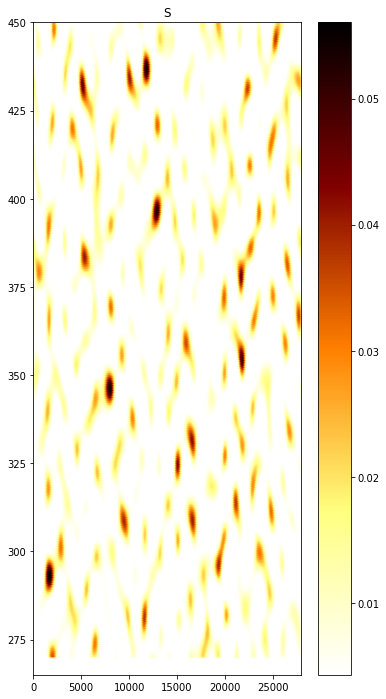

In [56]:
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0:]/86400,np.sqrt(S[it0:]),shading='Gouraud',cmap='afmhot_r')
plt.ylim(265,450)
plt.colorbar()
plt.title("S")
#plt.savefig("s_field.pdf",bbox_inches='tight')

## Counting patches

Here we'll introduce an algorithm for counting contiguous patches in a binary mask. We want to be able to identify _how many_ patches there are, not necessarily how large they are. So we can't simply integrate the mask (though that also has its uses). We could invoke a sophisticated cluster-finding algorithm or machine learning pattern, but that's definitely overkill.

So instead we implement a simple algorithm inspired by the classical computation problem, The Game of Life. We add a margin of ghost cells on each side, with an extra margin of `dx` and `dt`, using free boundaries on the time axis and periodic boundaries on the spatial axis. We define a box of width 2`dx` and height 2`dt`. We scan the box along each row, and at each step, if the central cell has a value of 1, consider how many other cells in the box have a value of 1 as opposed to 0. If any other cell in the box has a value of 1, the central cell is reset to 0. What this means is that when the box reaches the last cell in a patch, only one cell is left from that patch, and the box has only 1 non-zero cell. That means the last cell is left alone, and will count toward the total at the end.

Once the box has reached the end of the domain, we sum the value of the entire grid. Since a cell can have only a value of 0 or 1, and we now have 1 "black" cell per patch, this sum is therefore the number of patches. This algorithm has _O(N)_ complexity, specifically $N_xN_y(4d_xd_y-1)$ FLOPs, where $N=N_xN_y$.

In [57]:
def count_blocks(mask,dx,dt):
    dsh = mask.shape
    nt = dsh[0]
    nx = dsh[1]
    dmask = np.zeros(np.array(mask.shape)+[2*dt,2*dx])
    dmask[dt:-dt,dx:-dx] = mask[:,:]
    dmask[dt:-dt,0:dx] = mask[:,-dx:]
    dmask[dt:-dt,-dx:] = mask[:,0:dx]
    
    ict = 0
    for it in range(nt+dt,dt,-1):
        for ix in range(dx,nx+dx):
            if dmask[it,ix]==1:
                if np.sum(dmask[it-dt:it+dt,ix-dx:ix+dx])>1:
                    dmask[it,ix]=0
    
    ict = np.sum(dmask[dt:-dt,dx:-dx])
    return ict,dmask[dt:-dt,dx:-dx]

If we apply this to a mask of the forcing field, where a cell is 1 if the forcing is greater than a threshold value, and 0 otherwise, we can obtain a mask showing where and when the major forcings are. If we plot the coordinates of the cells identified as being representative of their patches as blue stars, we can see the algorithm does fairly well.

149.0


Text(0.5, 1.0, 'S Mask')

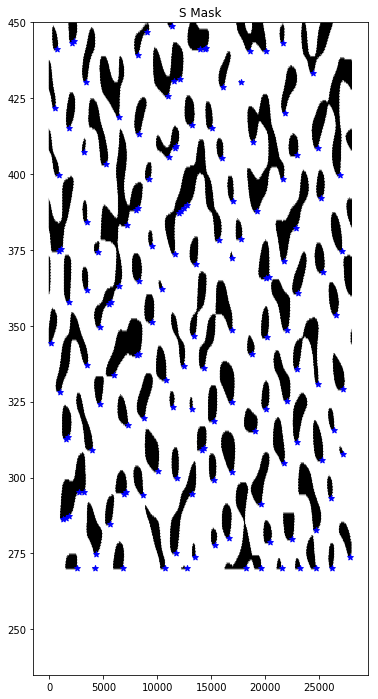

In [58]:
smask = (S[it0-100:]>0.6e-4)*1.0

sct,scmask = count_blocks(smask,5,5)
print(sct)
sts = t[it0-100:][np.where(scmask>0.5)[0]]/86400
sxs = x[np.where(scmask>0.5)[1]]/1e3
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0-100:]/86400,smask,shading='Gouraud',cmap='Greys')
plt.scatter(sxs,sts,marker='*',color='b')
plt.ylim(235,450)
plt.title("S Mask")

Now let's actually take a look at some the output. First we'll look at the inputs: the forcing and the background.

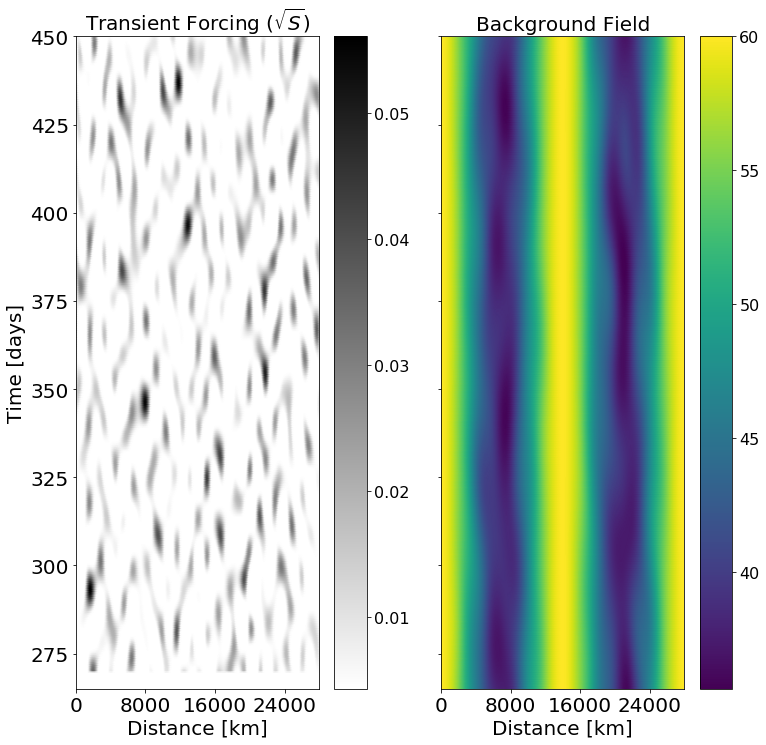

In [59]:
fig,axes=plt.subplots(1,2,figsize=(12.,12.),sharey=True)
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,np.sqrt(S[it0:]),shading='Gouraud',cmap='gist_gray_r')
axes[0].set_ylim(265,450)
cbar=plt.colorbar(im1,ax=axes[0])#,label="Forcing Strength [m/s$^2$]")
cbar.ax.tick_params(labelsize=16)
axes[0].set_title(r"Transient Forcing $(\sqrt{S})$",fontsize=20)
im2=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(C[it0:]),shading='Gouraud',cmap='viridis')
#plt.ylim(270,300)
#plt.xlim(7000,12000)
cbar=plt.colorbar(im2,ax=axes[1])#,label="Background Amplitude",ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_title("Background Field",fontsize=20)
axes[0].set_ylabel("Time [days]",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=20)
axes[0].tick_params(axis="x",labelsize=20)
axes[0].set_xticks(np.arange(0,30000,8000))
axes[1].tick_params(axis="x",labelsize=20)
axes[1].set_xticks(np.arange(0,30000,8000))
axes[0].tick_params(axis="y",labelsize=20)

plt.savefig("figure_pdf/force_6.0.png")


You can see that this input produces sporadic blocking, some of it quite large and long-lasting. We can see this as large concentrations of LWA, as well as as sharp features in the flux.

Text(0.5, 1.0, 'F')

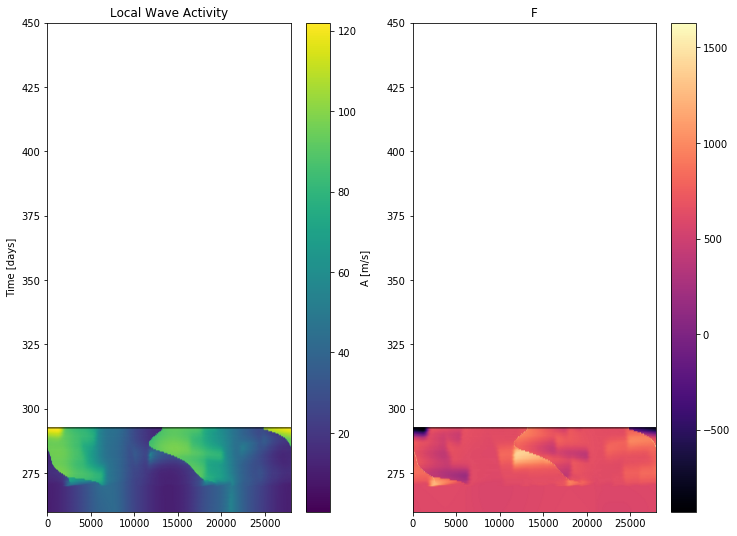

In [60]:
plt.figure(figsize=(12.,9))
plt.subplot(121)
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],
               shading='Gouraud',cmap='viridis')
plt.ylim(260,450)
plt.ylabel("Time [days]")
plt.colorbar(label="A [m/s]")
plt.title("Local Wave Activity")

plt.subplot(122)
plt.pcolormesh(x/1e3,t[it0:]/86400,F[it0:],shading='Gouraud',cmap='magma')
plt.ylim(260,450)
plt.colorbar()
plt.title("F")
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

We can get a sense for what's going on here by looking at the individual components of the equation being solved.

In [61]:
import matplotlib.colors as colors

ValueError: arange: cannot compute length

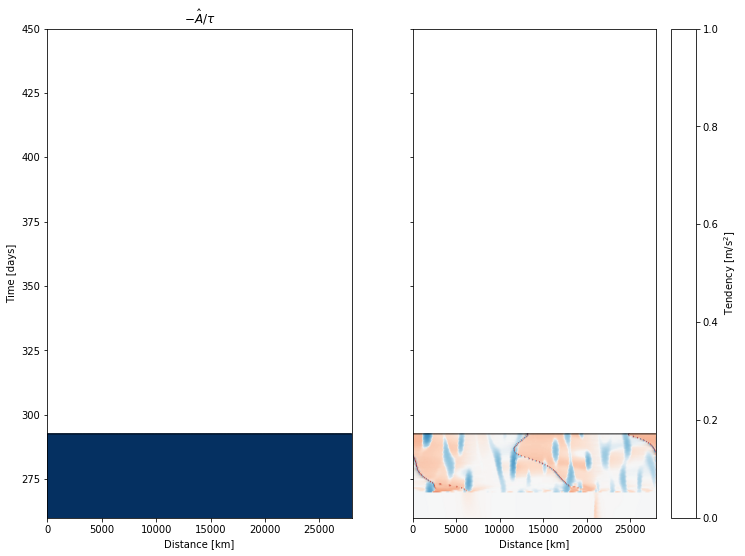

In [63]:

fterm = -np.gradient(F[:],x[1]-x[0],axis=1)
Dterm = 3.26e5*np.gradient(np.gradient(Ahat,x[1]-x[0],axis=1),x[1]-x[0],axis=1)
ahtau = -Ahat/(10.0*86400.0)
fmin = -np.amax(abs(fterm))
fmax = np.amax(abs(fterm))
ahmin = -np.amax(abs(ahtau))
ahmax = np.amax(abs(ahtau))
dmin = -np.amax(abs(Dterm))
dmax = np.amax(abs(Dterm))
smin = -np.amax(abs(S))
smax = np.amax(abs(S))
vmin = np.amin([fmin,ahmin,dmin,smin])
vmax = np.amax([fmax,ahmax,dmax,smax])

fig,axes=plt.subplots(1,2,figsize=(12.,9),sharey=True)
axes[0].pcolormesh(x/1e3,t[:]/86400,-(Ahat)/(10.0*86400.0),
                   shading='Gouraud',cmap='RdBu_r',
                   norm=colors.SymLogNorm(linthresh=1.0e-5, 
                                          linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(260,450)
axes[0].set_title("$-\hat{A}/\\tau$")
axes[0].set_ylabel("Time [days]")

im=axes[1].pcolormesh(x/1e3,t[:]/86400,fterm,
                      shading='Gouraud',cmap='RdBu_r',
                      norm=colors.SymLogNorm(linthresh=1.0e-5, 
                                             linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_ylim(260,450)
axes[1].set_xlabel("Distance [km]")
axes[0].set_xlabel("Distance [km]")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
axes[1].set_title("$-\partial_xF$")
#plt.savefig("eqn_components1.png",bbox_inches='tight')

The LWA decay is strongest during blocking events, which makes sense. Flux divergence is highest on the leading edges of blocking events, as well as in the tail when the remnant of a block is advected away. The flux convergence is highest downstream of the block. There's also localized divergence where forcing is injecting LWA. 

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(12.,9),sharey=True)
im=axes[0].pcolormesh(x/1e3,t[:]/86400,S,shading='Gouraud',cmap='RdBu_r',
                      norm=colors.SymLogNorm(linthresh=1.0e-5, 
                                             linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]")
axes[0].set_title("$\hat{S}$")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
axes[1].pcolormesh(x/1e3,t[:]/86400,Dterm,shading='Gouraud',cmap='RdBu_r',
                   norm=colors.SymLogNorm(linthresh=1.0e-5, 
                                          linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_title("$D\partial_x^2\hat{A}$")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
#plt.savefig("eqn_components2.png",bbox_inches='tight')

The diffusion term is effectively negligible except for on the leading edges of blocks, where it acts to smooth and avoid numerical problems where the shock forms.

Now of course, fundamentally a blocking event is characterized by a slowdown in the mean eastward flow.

In [39]:
ua = 40-cond.alpha*(Ahat+model.A0[np.newaxis,:])

In [40]:
np.linspace(0,30000,1)

array([0.])

Here large amounts of LWA correspond to large slowdowns or even reversals in mean eastward flow. Note that, in particular, the leading edge is characterized by extremely sharp changes in flow speed. This is the leading edge of the traffic jam.


It's also fun to plot some particle trajectories.

In [ ]:
def trajectory_ua(t0,xx,times,ua,L):
    traj = []
    ttimes = []
    posx = 0
    it0 = np.where(times>=t0)[0]
    if len(it0)>0:
        it0 = it0[0]
    ttimes.append(times[it0])
    traj.append(posx)
    while posx < L and ttimes[-1]<times[-1]:
        dt = times[it0+1]-times[it0]
        vx = np.interp(posx,xx,0.5*(ua[it0,:]+ua[it0+1,:])) #Leapfrog
        posx += vx*dt
        ttimes.append(ttimes[-1]+dt)
        traj.append(posx)
        it0+=1
    return np.array(ttimes),np.array(traj)

In [ ]:
plt.figure(figsize=(6.,9))
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],
               shading='Gouraud',cmap='viridis')
plt.ylim(150,450)
plt.colorbar()
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='w')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

Amazing! Look at that flow reversal in the first block! This is even more clear if we only plot the trajectories.

In [ ]:
plt.figure(figsize=(6.,9))
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='k')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

Noboru proposed that flux saturation might be a good proxy for measuring blocking onset. Let's take a look at that.

In [ ]:
gamma = 4*cond.alpha*F/C**2

The flux saturation $\Gamma(x,t)$ is defined as $$\Gamma(x,t) = \frac{4\alpha F(x,t)}{C^2(x)}.$$

In [ ]:
plt.figure(figsize=(6.,8))
im=plt.pcolormesh(x/1e3,t[it0:]/86400,
                  np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),
                  shading='Gouraud',cmap='inferno_r')
plt.colorbar(im,label="Log(1-$\Gamma$)")
#plt.contour(x/1e3,t[it0:]/86400,(gamma)[it0:],0.99999,colors='g')
plt.ylim(265,450)
plt.title("Log Proximity to Saturation")
plt.ylabel("Time [days]")
plt.xlabel("Distance [km]")
print(gamma.max())
#plt.savefig("gamma.png",bbox_inches='tight')

# 2c

Rather than plotting the saturation itself, we instead plot $\log_{10}(1-\Gamma)$. This means we can see the asymptotic approach to $\Gamma=1$, and actually see that the transition is rather sharp, and makes it clear that blocks are outlined by regions of flux saturation, with the highest saturation actually downstream of the area of strongest slowdown.

This becomes then a tempting mask for identifying blocks.

In [ ]:
masked = gamma.copy()
masked[np.where(gamma<0.99999)]=0
masked[np.where(gamma>=0.99999)]=1

In [ ]:

plt.figure(figsize=(8.,10))
plt.pcolormesh(x/1e3,t[it0:]/86400,(masked)[it0:],cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("Flux Saturated Yes/No")

Here we see however that this is actually quite spotty, and therefore perhaps not ideal. We can instead consider a few other measures: the time tendency of $A$, and the absolute value of the flux divergence/convergence.

Text(0.5, 1.0, '$|\\partial_t A|$')

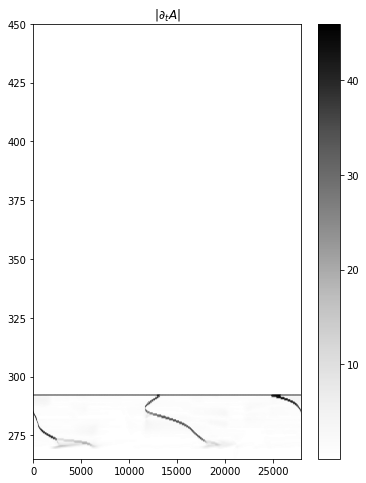

In [64]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,
               abs(np.gradient((Ahat+model.A0[np.newaxis,:])[it0:],axis=0)),
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_t A|$")

Text(0.5, 1.0, '$|\\partial_x F|$')

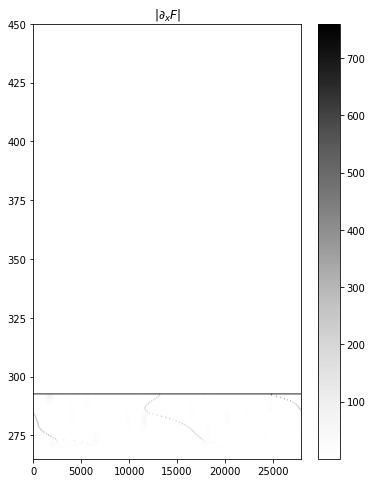

In [66]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient(F[it0:],axis=1)),
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x F|$")

These trace the leading edges, but by playing with the parameters we can find examples of false positives and false negatives.

Another measure that may be more useful is actually much more direct: the local flow gradient. This is a direct probe of sharp slowdowns.

Text(0.5, 1.0, '$|\\partial_x u|$')

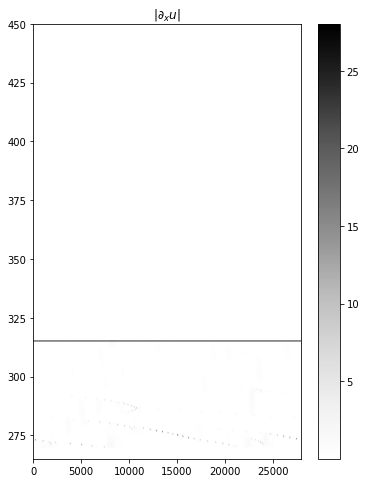

In [67]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,
               abs(np.gradient(ua[it0:],axis=1)),
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x u|$")

To use these quantities as masks, we can compute the signficance of the metric relative to the background by computing its difference from the mean relative to the standard deviation.

Text(0.5, 1.0, '$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$')

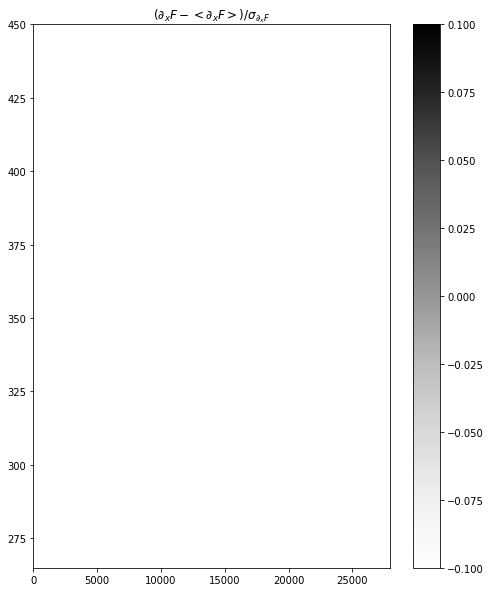

In [68]:
plt.figure(figsize=(8.,10))
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,
               ((grad-np.mean(grad))/np.std(grad)),
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>"+
          "\\right)/\sigma_{\partial_x F}$")

Text(0.5, 1.0, '$\\left(<\\partial_x u> - \\partial_xu\\right)/\\sigma_{\\partial_x u}$')

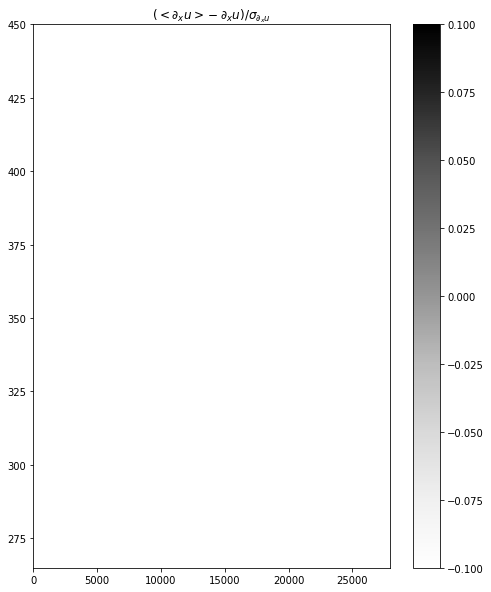

In [69]:
plt.figure(figsize=(8.,10))
ugrad = -(np.gradient(ua[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,
               ((ugrad-np.mean(ugrad))/np.std(ugrad)),
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(<\partial_x u> - \partial_xu"+
          "\\right)/\sigma_{\partial_x u}$")

Here it is clear that we can identify these sharp features with a fair bit of confidence. Let's mask the flux divergence to a certain significance threshold.

/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Text(0.5, 1.0, '$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$ > 10 Binary Flag')

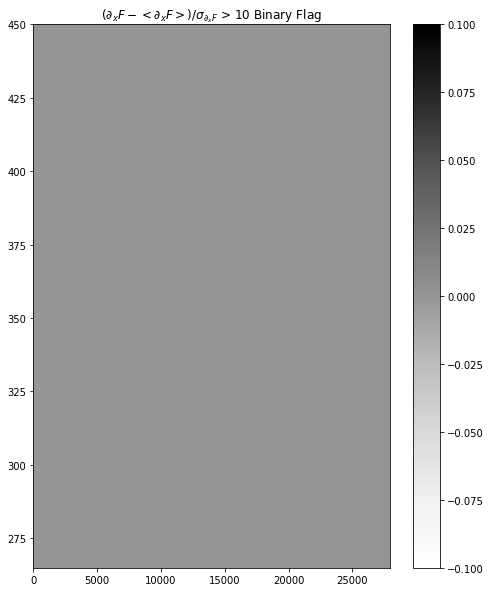

In [70]:
plt.figure(figsize=(8.,10))
thresh = 10
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,
               ((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,
               shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/"+
          "\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)

/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


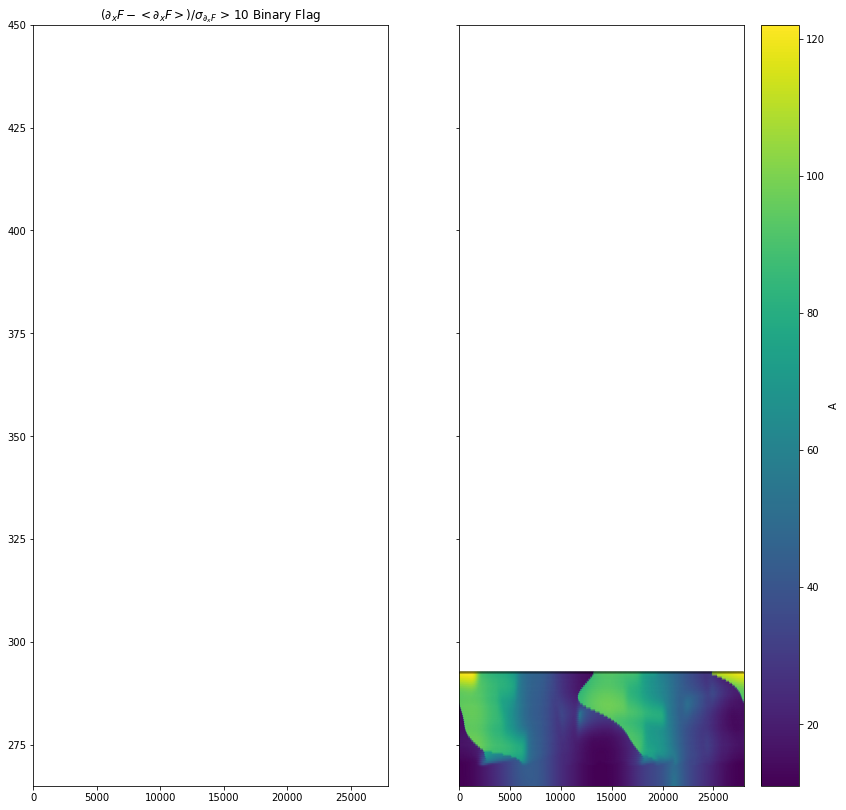

In [71]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,
                       ((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,
                       shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(\partial_x F - <\partial_x F>\\right)"+
                  "/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,
                         (Ahat+model.A0[np.newaxis,:])[it0:],
                         shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

What is this?! At 10 sigma significance, one of our blocks vanishes! Let's look at the flow gradient.

/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


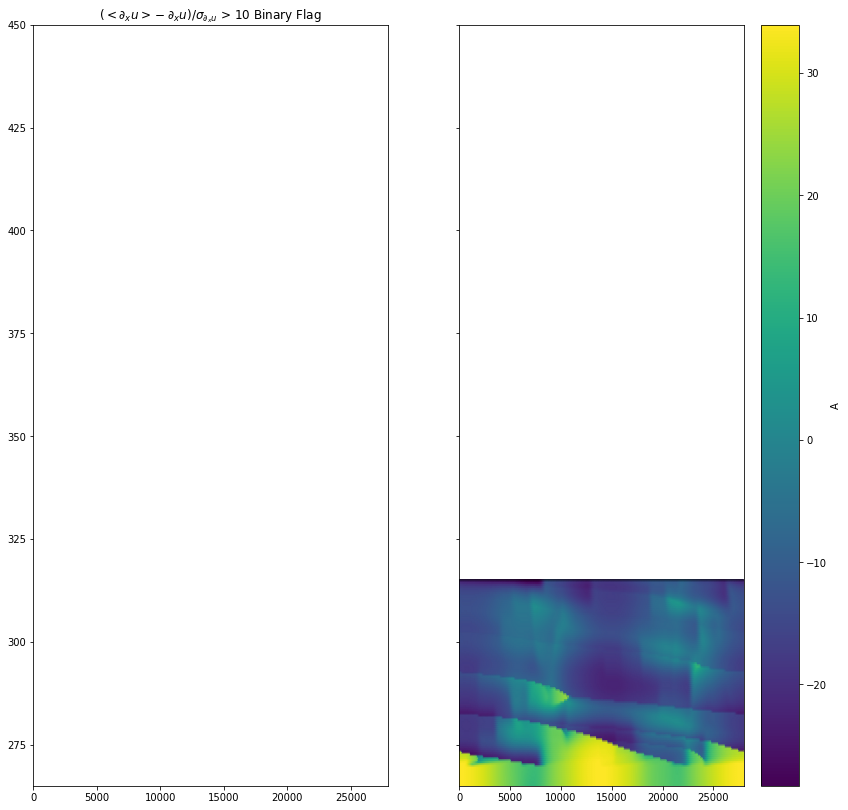

In [72]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)
threshu = 10
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
                       shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(<\partial_x u> - \partial_xu\\right)/"+
                  "\sigma_{\partial_x u}$ > %d Binary Flag"%threshu)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,ua[it0:],
                         shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

In this metric, we __do__ see each block at 10 sigma significance.

In [48]:
umask = ((ugrad - np.mean(ugrad))/np.std(ugrad) > threshu)*1.0
uct,umask = count_blocks(umask,80,10)
print(uct)
uts = t[it0:][np.where(umask>0.5)[0]]/86400
uxs = x[np.where(umask>0.5)[1]]/1e3

2.0


When we use our `count_blocks()` algorithm, it identifies 7 blocks. That's not bad. Let's plot where those are, with blue stars over the mask and red stars over the eastward flow map.

/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


NameError: name 'uxs' is not defined

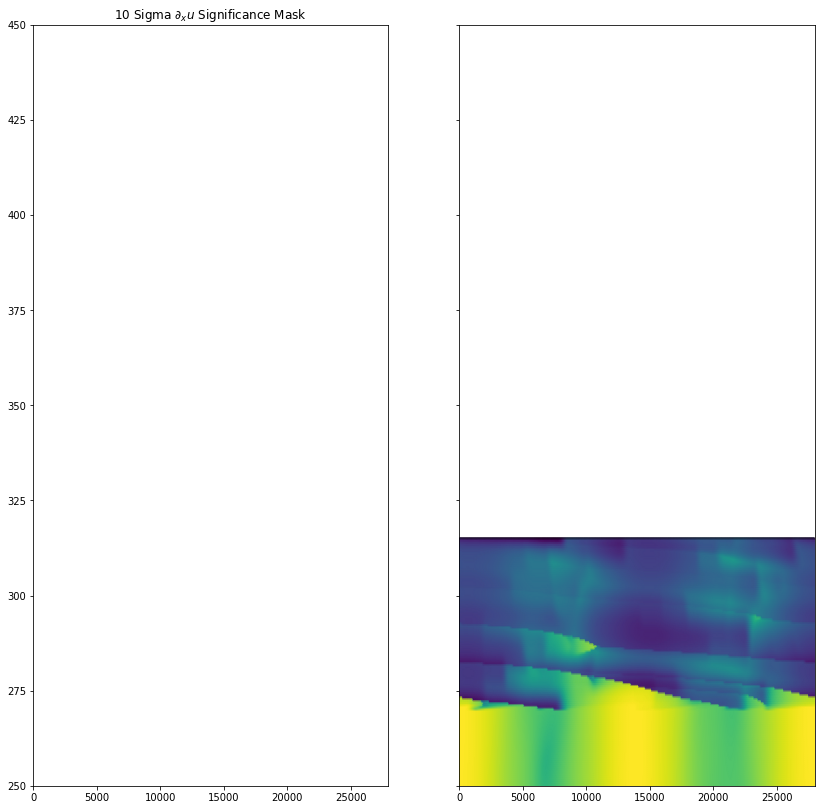

In [73]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
                       shading='Gouraud',cmap='Greys')
axes[0].set_ylim(250,450)
axes[0].set_title("%d Sigma $\partial_x u$ Significance Mask"%threshu)
im2 = axes[1].pcolormesh(x/1e3,t[it0-50:]/86400,ua[it0-50:],
                         shading='Gouraud',cmap='viridis')
axes[0].scatter(uxs,uts,s=40,marker='*',color='b')
axes[1].scatter(uxs,uts,s=40,marker='*',color='r')
axes[1].set_ylim(250,450)
axes[0].set_ylabel("Time [days]")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
axes[1].set_title("Eastward Wind")
plt.colorbar(im2,ax=axes[1],label="u [m/s]")
#plt.savefig("blockidentification.png",bbox_inches='tight')


# 2d

That's pretty good! Now let's look at LWA and forcing side-by-side. We'll see here that there isn't always an obvious correlation between individual forcing events and blocks--it's a matter of built-up flux!

NameError: name 'uxs' is not defined

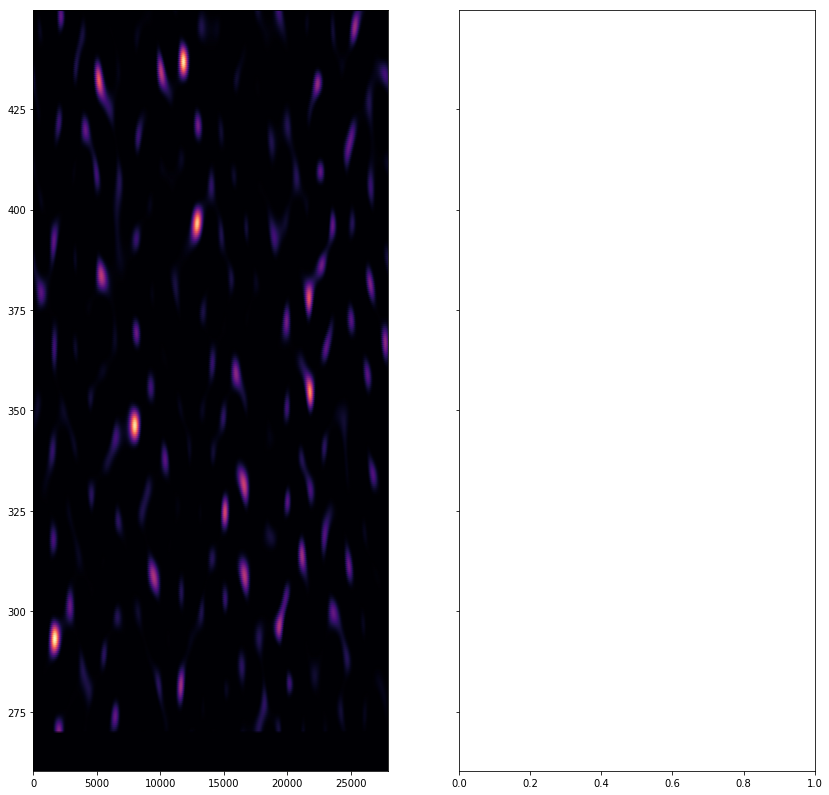

In [74]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,S[it0:],
                       shading='Gouraud',cmap='magma')
axes[0].scatter(uxs,uts,s=40,marker='*',color='w')
axes[0].set_ylim(265,450)
axes[0].set_title("S")
#plt.legend(loc='best')
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,
                         (Ahat+model.A0[np.newaxis,:])[it0:],
                         shading='Gouraud',cmap='viridis')
axes[1].scatter(uxs,uts,s=40,marker='*',color='r')
axes[1].set_ylim(265,450)
axes[1].set_title("A")
plt.colorbar(im1,ax=axes[0],label="S")
plt.colorbar(im2,ax=axes[1],label="A")

/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in maximum
/project2/tas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


NameError: name 'uxs' is not defined

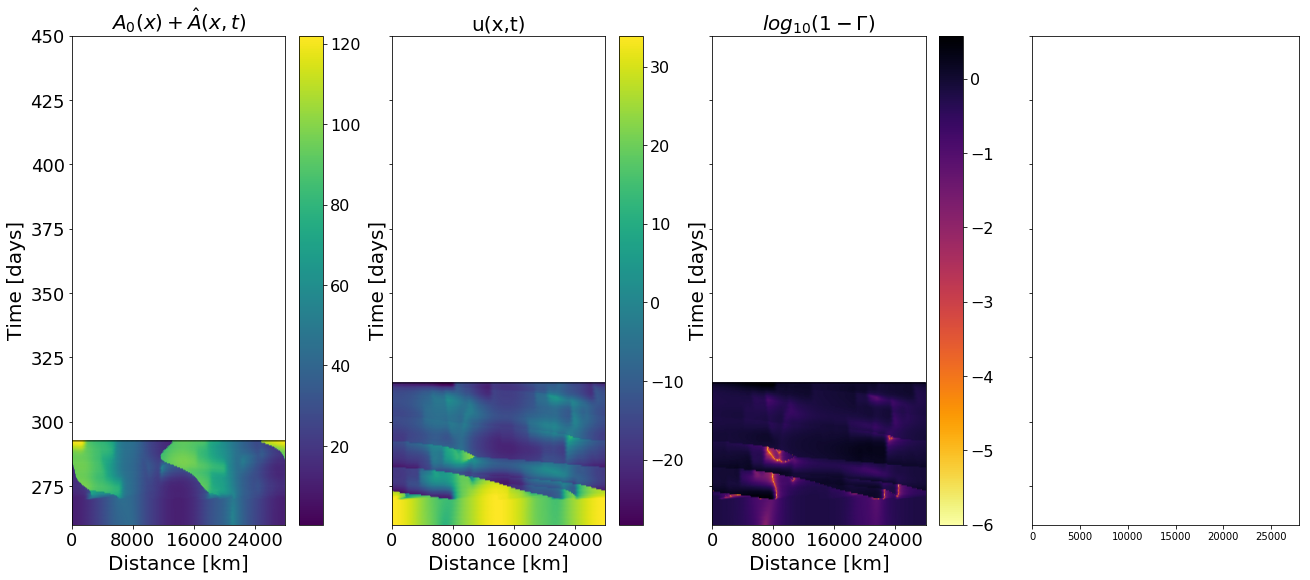

In [75]:
fig,axes=plt.subplots(1,4,figsize=(22.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],
                      shading='Gouraud',cmap='viridis')
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=18)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',
                      cmap='viridis')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=18)
axes[1].set_xticks(np.arange(0,30000,8000))



im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,
                  np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),
                  shading='Gouraud',cmap='inferno_r')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title(r"$log_{10}(1-\Gamma)$",fontsize=20)
axes[2].tick_params(axis="x",labelsize=18)
axes[2].set_xticks(np.arange(0,30000,8000))


im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
                       shading='Gouraud',cmap='Greys')
axes[3].scatter(uxs,uts,s=40,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title("mask",fontsize=20)
axes[3].tick_params(axis="x",labelsize=18)
axes[3].set_xticks(np.arange(0,30000,8000))

# plt.savefig("figure_pdf/figure_3.0.png")

# 2a,b

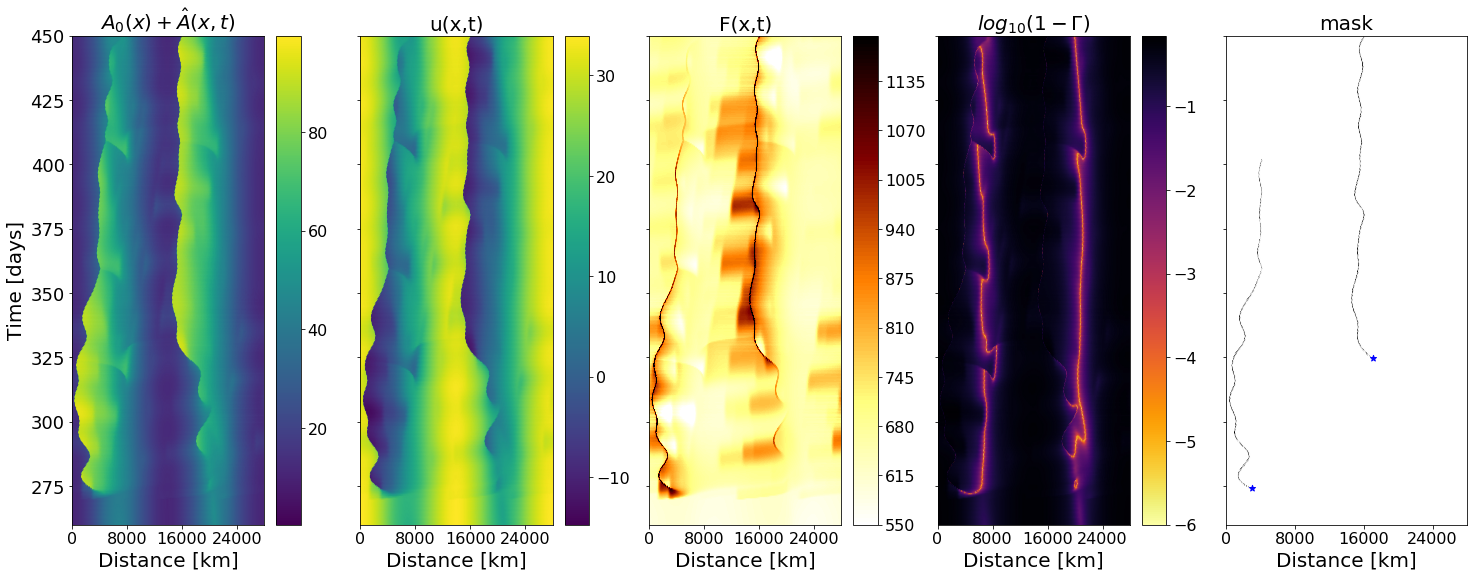

In [55]:
fig,axes=plt.subplots(1,5,figsize=(25.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],
                      shading='Gouraud',cmap='viridis')
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=16)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',
                      cmap='viridis')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=16)
axes[1].set_xticks(np.arange(0,30000,8000))



im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
                  np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),
                  shading='Gouraud',cmap='inferno_r')
cbar=plt.colorbar(im,ax=axes[3])
cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title(r"$log_{10}(1-\Gamma)$",fontsize=20)
axes[3].tick_params(axis="x",labelsize=16)
axes[3].set_xticks(np.arange(0,30000,8000))



im=axes[2].contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(550,1200,5),cmap='afmhot_r')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title("F(x,t)",fontsize=20)
axes[2].tick_params(axis="x",labelsize=16)
axes[2].set_xticks(np.arange(0,30000,8000))



im=axes[4].pcolormesh(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
                       shading='Gouraud',cmap='Greys')
axes[4].scatter(uxs,uts,s=40,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[4].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[4].set_xlabel("Distance [km]",fontsize=20)
axes[4].set_title("mask",fontsize=20)
axes[4].tick_params(axis="x",labelsize=16)
axes[4].set_xticks(np.arange(0,30000,8000))

plt.savefig("figure_pdf/figure_all_3.0.png")

# 2a,b

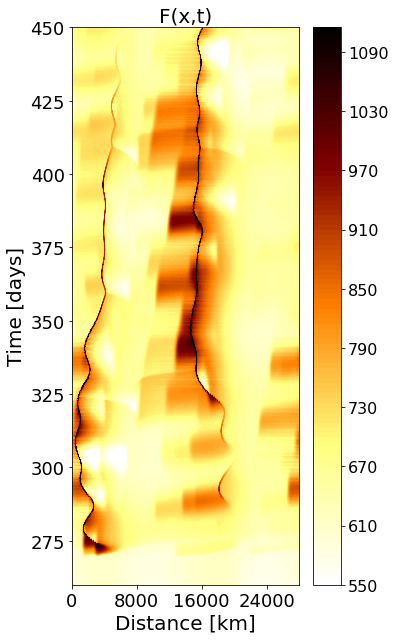

In [54]:

plt.figure(figsize=(5.5,9))
im=plt.contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(550,1120,5),cmap='afmhot_r')
cbar=plt.colorbar(im)
cbar.ax.tick_params(labelsize=16)
plt.ylim(260,450)
plt.xlabel('Distance [km]', fontsize=20)
plt.xticks(np.arange(0,30000,8000), fontsize=18)
plt.tick_params(labelsize=18)
plt.ylabel('Time [days]', fontsize=20)
plt.title("F(x,t)", fontsize=20)
plt.tight_layout()
# plt.savefig("figure_pdf/lwa_flux_random.pdf")




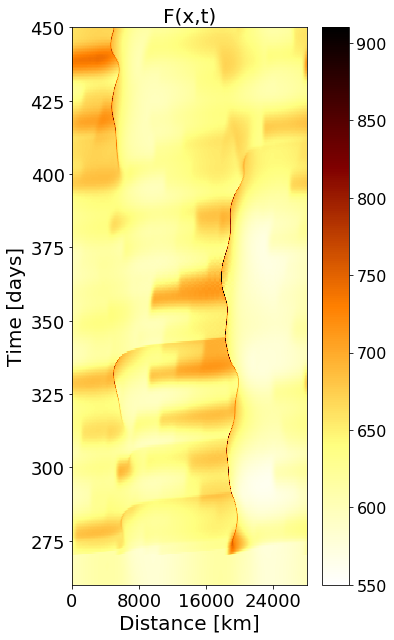

In [127]:

plt.figure(figsize=(5.5,9))
im=plt.pcolormesh(x/1e3,t[it0:]/86400,F[it0:],vmin=550, vmax=910,cmap='afmhot_r')
cbar=plt.colorbar(im)
cbar.ax.tick_params(labelsize=16)
plt.ylim(260,450)
plt.xlabel('Distance [km]', fontsize=20)
plt.xticks(np.arange(0,30000,8000), fontsize=18)
plt.tick_params(labelsize=18)
plt.ylabel('Time [days]', fontsize=20)
plt.title("F(x,t)", fontsize=20)
plt.tight_layout()
# plt.savefig("figure_pdf/lwa_flux_random.pdf")


